In [37]:
import pandas as pd
import numpy as np


connections = pd.read_csv("Data/Walking Distances Gate-to-Gate.csv")

pair_dists = connections.to_numpy().astype(np.float64)

# Handle NaNs or missing values if any
pair_dists = np.nan_to_num(pair_dists, nan=np.inf)  # or set to large value

# Min-max normalization (excluding infinities)
finite_vals = pair_dists[np.isfinite(pair_dists)]
min_val = np.min(finite_vals)
max_val = np.max(finite_vals)

normalized_dists = (pair_dists - min_val) / (max_val - min_val)
normalized_dists[~np.isfinite(pair_dists)] = 1.0  # keep inf as 1 (furthest apart)

pair_dists = normalized_dists

median_distance = np.median(pair_dists[np.isfinite(pair_dists)])  # Exclude infinities (or NaNs)
print(f"Median distance: {median_distance}")

Median distance: 0.4467781402936378


# Code to construct clustered medoids

In [35]:
from sklearn.metrics import pairwise_distances_argmin_min

def k_medoids_single_run(pair_dists, k, max_iter=300):
    n = pair_dists.shape[0]
    curr_medoids = np.random.choice(n, k, replace=False)

    for _ in range(max_iter):
        labels = np.argmin(pair_dists[:, curr_medoids], axis=1)
        new_medoids = np.copy(curr_medoids)

        for cluster_id in range(k):
            cluster_points = np.where(labels == cluster_id)[0]
            if len(cluster_points) == 0:
                continue
            intra_cluster_dists = pair_dists[np.ix_(cluster_points, cluster_points)]
            total_dists = np.sum(intra_cluster_dists, axis=1)
            new_medoids[cluster_id] = cluster_points[np.argmin(total_dists)]

        if np.all(curr_medoids == new_medoids):
            break
        curr_medoids = new_medoids

    final_labels = np.argmin(pair_dists[:, curr_medoids], axis=1)
    return final_labels, curr_medoids

def compute_medoids_mse(pair_dists, labels, medoids):
    medoid_map = np.array(medoids)[labels]
    approx_dists = pair_dists[np.ix_(medoid_map, medoid_map)]
    mse = np.sum((pair_dists - approx_dists) ** 2)
    return mse

def k_medoids(pair_dists, k, max_iter=300, n_init=1000, verbose=False):
    best_loss = float("inf")
    best_labels, best_medoids = None, None

    for i in range(n_init):
        labels, medoids = k_medoids_single_run(pair_dists, k, max_iter)
        mse_loss = compute_medoids_mse(pair_dists, labels, medoids)

        if verbose:
            print(f"[Run {i+1}] MSE Loss: {mse_loss:.6f}")

        if mse_loss < best_loss:
            best_loss = mse_loss
            best_labels = labels
            best_medoids = medoids

    return best_labels, best_medoids



labels, medoids = k_medoids(pair_dists, k=6)
print("Cluster assignments:", labels)
print("Medoid indices:", medoids)

mse_loss = compute_medoids_mse(pair_dists, labels, medoids)
print("MSE loss of medoid approximation:", mse_loss)

Cluster assignments: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0
 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Medoid indices: [73 35  6 87 19 57]
MSE loss of medoid approximation: 327405474.0


In [3]:
def get_medoid_distance_matrix(pair_dists, medoids):
    """
    Returns the pairwise distance matrix between medoids.

    Args:
        pair_dists (np.ndarray): Full NxN pairwise distance matrix.
        medoids (list or np.ndarray): List of indices of medoid points.

    Returns:
        np.ndarray: KxK distance matrix between medoids.
    """
    medoids = np.array(medoids)
    return pair_dists[np.ix_(medoids, medoids)]

pair_dists_medoid = get_medoid_distance_matrix(pair_dists, medoids)

print("Pairwise distance matrix between medoids:")
print(pair_dists_medoid)

Pairwise distance matrix between medoids:
[[   0. 1055. 1024. 1369.  459. 1329.]
 [1055.    0. 1813.  591. 1433. 2117.]
 [1024. 1813.    0. 1376.  653.  436.]
 [1369.  591. 1376.    0.  923. 1680.]
 [ 459. 1433.  653.  923.    0.  957.]
 [1329. 2117.  436. 1680.  957.    0.]]


# Function to linearize given set of pairwise distances

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
def optimize_1T_E_minus_1T_S(pair_dists, d=2, num_iters=10000, lr=1e-2, verbose=True):
    """
    Optimize E and S to minimize sum((1^T E_i - 1^T S_j - pair_dists[i,j])^2)
    
    pair_dists: torch.Tensor of shape (k, k)
    d: dimensionality of E and S
    """
    k = pair_dists.shape[0]
    
    # E and S are k x d matrices
    E = torch.randn((k, d), requires_grad=True)
    S = torch.randn((k, d), requires_grad=True)
    
    optimizer = optim.Adam([E, S], lr=lr)
    
    for iter in range(num_iters):
        optimizer.zero_grad()
        
        # 1^T E_i = sum over dim-1 (axis=1) → shape (k,)
        E_sum = E.sum(dim=1)  # shape (k,)
        S_sum = S.sum(dim=1)  # shape (k,)

        # Compute outer difference: E_sum[i] - S_sum[j]
        # Assume E_sum and S_sum are 1D tensors of shape (k,)
        E_sum = E_sum.view(-1, 1)  # Shape: (k, 1)
        S_sum = S_sum.view(1, -1)  # Shape: (1, k)

        diff_matrix = E_sum - S_sum  # Shape: (k, k)
        #torch.diagonal(diff_matrix).zero_()  # Set diagonal to 0 in-place


        # Compute loss
        loss = ((diff_matrix - pair_dists) ** 2).mean()
        loss.backward()
        optimizer.step()
        
        if verbose and iter % 100 == 0:
            print(f"Iter {iter}: Loss = {loss.item():.6f}")
    
    return E.detach(), S.detach(), loss.item()

def linearize_analytical(pair_dists):
    """
    Linearize the pairwise distance matrix using the analytical least-squares solution.

    Args:
        pair_dists (np.ndarray): Pairwise distance matrix of shape (k, k).

    Returns:
        E (np.ndarray): Source embedding vector of length k.
        S (np.ndarray): Target embedding vector of length k.
        residual (float): Total squared residual error.
    """
    k = pair_dists.shape[0]
    num_vars = 2 * k

    A = []
    b = []

    for i in range(k):
        for j in range(k):
            row = np.zeros(num_vars)
            row[i] = 1         # e_i
            row[k + j] = -1    # -s_j
            A.append(row)
            b.append(pair_dists[i, j])

    A = np.array(A)
    b = np.array(b)

    opt_sol, res, rank, s = np.linalg.lstsq(A, b, rcond=None)

    E = opt_sol[:k]
    S = opt_sol[k:]

    total_residual = res[0] if res.size > 0 else np.sum((A @ opt_sol - b) ** 2)

    return E, S, total_residual


In [ ]:
# Optimize to recover E and S
E_opt, S_opt, loss = linearize_analytical(pair_dists)
print("Recovered E sums:", E_opt)
print("Recovered S sums:", S_opt)

Recovered E sums: [683.9140625  609.49739583 561.58072917 533.45572917 462.87239583
 449.43489583 438.93489583 426.12239583 402.51822917 397.8515625
 393.58072917 389.24739583 379.70572917 374.8515625  369.45572917
 364.62239583 353.76822917 342.4140625  341.76822917 347.93489583
 298.95572917 298.20572917 314.70572917 355.95572917 363.62239583
 406.70572917 757.01822917 735.4765625  708.64322917 561.45572917
 522.0390625  496.05989583 479.43489583 414.51822917 414.51822917
 403.95572917 388.12239583 398.18489583 402.01822917 404.89322917
 410.55989583 415.2265625  418.74739583 425.64322917 429.14322917
 437.20572917 440.62239583 441.24739583 445.6015625  477.30989583
 543.43489583 541.05989583 543.6640625  539.0703125  536.77864583
 536.5703125  532.23697917 532.40364583 532.40364583 532.09114583
 541.49739583 527.7890625  539.74739583 573.74739583 603.99739583
 624.62239583 647.62239583 647.62239583 523.34114583 552.54947917
 548.9140625  525.04947917 520.6953125  525.90364583 506.38

In [6]:
# Save the optimized E and S matrices

np.savetxt("Data/E_optimized.csv", E_opt.sum(dim=1).numpy(), delimiter=",")
np.savetxt("Data/S_optimized.csv", S_opt.sum(dim=1).numpy(), delimiter=",")


In [30]:
# Optimize to recover E and S
E_opt, S_opt, loss = linearize_analytical(pair_dists_medoid)
print("Recovered E sums:", E_opt)
print("Recovered S sums:", S_opt)

Recovered E sums: [394.47222222 689.97222222 405.47222222 511.63888889 259.30555556
 608.30555556]
Recovered S sums: [-394.47222222 -689.97222222 -405.47222222 -511.63888889 -259.30555556
 -608.30555556]


In [33]:
# 1^T E_i = sum over dim-1 (axis=1) → shape (k,)
E_sum = E_opt  # shape (k,)
S_sum = S_opt  # shape (k,)

# Compute outer difference: E_sum[i] - S_sum[j]
# Assume E_sum and S_sum are 1D tensors of shape (k,)
E_sum = E_sum.reshape(-1, 1)  # Shape: (k, 1)
S_sum = S_sum.reshape(1, -1)  # Shape: (1, k)

diff_matrix = E_sum - S_sum  # Shape: (k, k)

print("Pairwise distance matrix between medoids after optimization:")
print(diff_matrix)

Pairwise distance matrix between medoids after optimization:
[[ 788.94444444 1084.44444444  799.94444444  906.11111111  653.77777778
  1002.77777778]
 [1084.44444444 1379.94444444 1095.44444444 1201.61111111  949.27777778
  1298.27777778]
 [ 799.94444444 1095.44444444  810.94444444  917.11111111  664.77777778
  1013.77777778]
 [ 906.11111111 1201.61111111  917.11111111 1023.27777778  770.94444444
  1119.94444444]
 [ 653.77777778  949.27777778  664.77777778  770.94444444  518.61111111
   867.61111111]
 [1002.77777778 1298.27777778 1013.77777778 1119.94444444  867.61111111
  1216.61111111]]


In [48]:
e_list = E_opt.sum(dim=1).numpy()
s_list = S_opt.sum(dim=1).numpy()

e_list = e_list[labels]
s_list = s_list[labels]
# Save the optimized E and S matrices

np.savetxt("Data/E_optimized_clust.csv", e_list, delimiter=",")
np.savetxt("Data/S_optimized_clust.csv", s_list, delimiter=",")


# Find optimal clustering level

Running k-medoids with k = 5
MSE loss of medoid approximation: 80.96381453765478
MSE of linear approximation for k=5: 1.771583
Total loss for k=5: 82.735397
Running k-medoids with k = 6
MSE loss of medoid approximation: 55.00887413543959
MSE of linear approximation for k=6: 2.015179
Total loss for k=6: 57.024053
Running k-medoids with k = 7
MSE loss of medoid approximation: 38.764321298457304
MSE of linear approximation for k=7: 2.910804
Total loss for k=7: 41.675125
Running k-medoids with k = 8
MSE loss of medoid approximation: 31.951562329516275
MSE of linear approximation for k=8: 3.780663
Total loss for k=8: 35.732226
Running k-medoids with k = 9
MSE loss of medoid approximation: 25.292810543179453
MSE of linear approximation for k=9: 5.725441
Total loss for k=9: 31.018251
Running k-medoids with k = 10
MSE loss of medoid approximation: 19.628649848710246
MSE of linear approximation for k=10: 6.035470
Total loss for k=10: 25.664120
Running k-medoids with k = 11
MSE loss of medoid ap

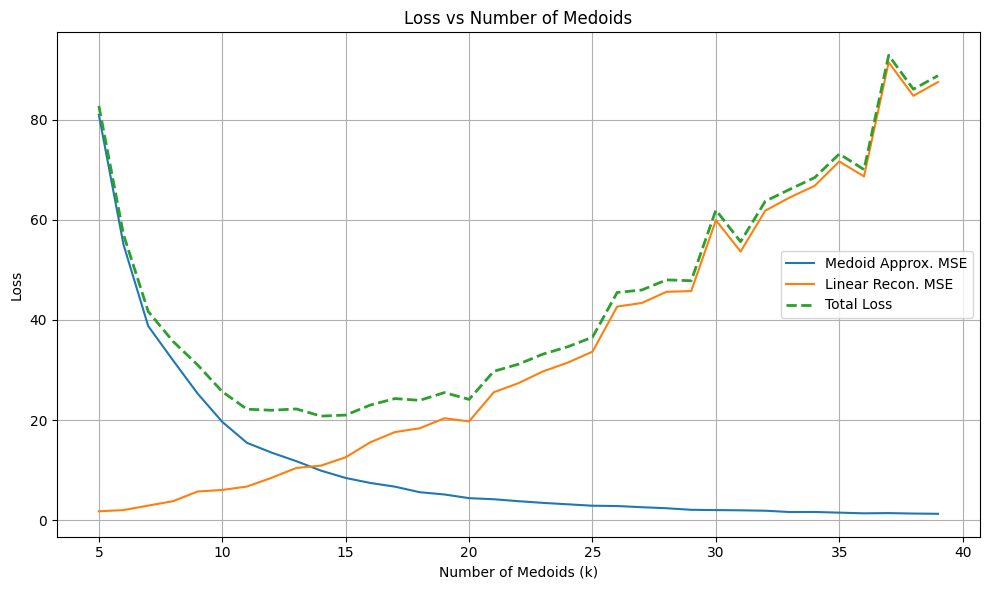


Minimum total loss 20.786123 at k=14


In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np

medoid_vals = list(range(5, 40))
medoid_approx_losses = []
linear_reconstruction_losses = []
total_losses = []

min_num_medoid = -1
min_medoid_loss = float("inf")

for k in medoid_vals:
    print("Running k-medoids with k =", k)

    labels, medoids = k_medoids(pair_dists, k=k)
    mse_loss = compute_medoids_mse(pair_dists, labels, medoids)
    print("MSE loss of medoid approximation:", mse_loss)

    pair_dists_medoid = get_medoid_distance_matrix(pair_dists, medoids)

    # Optimize to recover E and S
    E_opt, S_opt, loss = linearize_analytical(pair_dists_medoid)
    print(f"MSE of linear approximation for k={k}: {loss:.6f}")

    e_list = E_opt
    s_list = S_opt

    e_list = e_list[labels]
    s_list = s_list[labels]

    # Save the optimized E and S matrices

    np.savetxt(f"Data/E_optimized_clust{k}.csv", e_list, delimiter=",")
    np.savetxt(f"Data/S_optimized_clust{k}.csv", s_list, delimiter=",")


    total_loss = mse_loss + loss
    print(f"Total loss for k={k}: {total_loss:.6f}")

    # Save all losses
    medoid_approx_losses.append(mse_loss)
    linear_reconstruction_losses.append(loss)
    total_losses.append(total_loss)

    if total_loss < min_medoid_loss:
        min_medoid_loss = total_loss
        min_num_medoid = k

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(medoid_vals, medoid_approx_losses, label='Medoid Approx. MSE')
plt.plot(medoid_vals, linear_reconstruction_losses, label='Linear Recon. MSE')
plt.plot(medoid_vals, total_losses, label='Total Loss', linestyle='--', linewidth=2)

plt.xlabel('Number of Medoids (k)')
plt.ylabel('Loss')
plt.title('Loss vs Number of Medoids')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nMinimum total loss {min_medoid_loss:.6f} at k={min_num_medoid}")
